### Suffix tree construction

To be able to optimize the search for patterns within strings we need to do a couple of steps.
Firstly we need to construct a suffix tree that we can search through.
For this construction the most naive version would take O(n^2) time to construct and O(n^2) space
However it is possible to optimize it to O(n) runtime and O(n) space
Space can be optimized by change the edges from symbols to idx
runtime can be optimized by...

#### Naive construction

In [3]:
def construct_suffix_tree(s):
    # First we add $ to the string
    s = s + '$'
    suffix_tree = {}
    
    # make list of all suffixes
    suffixes = [s[i:] for i in range(len(s))]
    
    # insert suffixes
    for suffix in suffixes:
        starting_char = suffix[0]
        if starting_char not in suffix_tree:
            suffix_tree[starting_char] = []
        
        # Append the suffix to the list for the starting character
        suffix_tree[starting_char].append(suffix)
    
    # Return the suffix tree dictionary
    return suffix_tree

# Run the algoo
s = "banana"
suffix_tree = construct_suffix_tree(s)
print(suffix_tree)

{'b': ['banana$'], 'a': ['anana$', 'ana$', 'a$'], 'n': ['nana$', 'na$'], '$': ['$']}


Above might not give a usefull output. below is an outline of the algorithm 

In [ ]:
# Start at the root of Ni


# Find the longest path from the root which matches a prefix of S[i+1..m]$


# Match ends either at the node (say w) or in the middle of an edge [say (u, v)].


# If it is in the middle of an edge (u, v), break the edge (u, v) into two edges 
# by inserting a new node w just after the last character on the edge that matched a 
# character in S[i+l..m] and just before the first character on the edge that mismatched. 
# The new edge (u, w) is labelled with the part of the (u, v) label that matched with S[i+1..m], 
# and the new edge (w, v) is labelled with the remaining part of the (u, v) label.


# Create a new edge (w, i+1) from w to a new leaf labelled i+1 and it labels the new edge with 
# the unmatched part of suffix S[i+1..m]

#### code below is from the book and translated into python

In [9]:
class Range:
    def __init__(self, from_bytes, to_bytes):
        # from_bytes and to_bytes are expected to be byte-like objects (e.g., bytes, bytearray)
        self.from_bytes = from_bytes
        self.to_bytes = to_bytes

def range_length(r):
    # The length is calculated as the difference in lengths of the byte-like objects
    return len(r.to_bytes) - len(r.from_bytes)

# Example usage
r = Range(b'Hello', b'HelloWorld')
length = range_length(r)
print(length)  # Output: 5


5


In [10]:
class SuffixTreeNode:
    def __init__(self, leaf_label, range_obj, parent=None, sibling=None, child=None, suffix_link=None):
        self.leaf_label = leaf_label
        self.range = range_obj
        self.parent = parent
        self.sibling = sibling
        self.child = child
        self.suffix_link = suffix_link

def edge_length(node):
    # Calculate the edge length using the range_length function
    return range_length(node.range)

# Example usage
range_obj = Range(b'Hello', b'HelloWorld')
node = SuffixTreeNode(leaf_label=1, range_obj=range_obj)
length = edge_length(node)
print(length)  # Output: 5


5


In [11]:
class SuffixTreeNodePool:
    # Assuming the pool contains a list of nodes, we'll define it as an empty list initially.
    def __init__(self):
        self.nodes = []

class SuffixTree:
    def __init__(self, string, length, root=None):
        self.string = string           # Expecting a bytes-like object for the string
        self.length = length           # Length of the string
        self.root = root               # Root node of the suffix tree, if any
        self.pool = SuffixTreeNodePool()  # Initialize the pool of nodes

# Example usage
root_node = SuffixTreeNode(leaf_label=0, range_obj=Range(b'', b''))  # Example root node
suffix_tree = SuffixTree(string=b"example", length=len(b"example"), root=root_node)

print(suffix_tree.string)  # Output: b'example'
print(suffix_tree.length)  # Output: 7
print(suffix_tree.root.leaf_label)  # Output: 0


b'example'
7
0


In [12]:
class SuffixTreeNodePool:
    def __init__(self):
        self.nodes = []  # A list to hold the suffix tree nodes
        self.next_node = None  # The next available node

    def add_node(self, node):
        # Add a node to the pool and update the next available node
        self.nodes.append(node)
        self.next_node = node  # Update the next_node reference

    def get_next_node(self):
        # Return the next available node, or None if the pool is empty
        return self.next_node if self.nodes else None

# Example usage
node_pool = SuffixTreeNodePool()
node1 = SuffixTreeNode(leaf_label=1, range_obj=Range(b'Hello', b'HelloWorld'))
node2 = SuffixTreeNode(leaf_label=2, range_obj=Range(b'Example', b'ExampleTest'))

node_pool.add_node(node1)
node_pool.add_node(node2)

print(node_pool.get_next_node().leaf_label)  # Output: 2 (the most recently added node)


2


In [13]:
def new_node(suffix_tree, from_bytes, to_bytes):
    # Create a new SuffixTreeNode instance
    node = SuffixTreeNode(
        leaf_label=0,
        range_obj=Range(from_bytes, to_bytes)  # Initialize the range object with given 'from' and 'to' bytes
    )
    
    # Initialize other attributes of the node
    node.parent = None
    node.sibling = None
    node.child = None
    node.suffix_link = None

    # Add the new node to the pool
    suffix_tree.pool.add_node(node)

    return node

# Example usage
suffix_tree = SuffixTree(string=b"example", length=len(b"example"))
new_node1 = new_node(suffix_tree, b"abc", b"abcdef")
new_node2 = new_node(suffix_tree, b"def", b"defghi")

print(new_node1.range.from_bytes)  # Output: b'abc'
print(new_node2.range.to_bytes)    # Output: b'defghi'


b'abc'
b'defghi'


In [14]:
def free_suffix_tree(suffix_tree):
    # Clear the nodes in the pool
    suffix_tree.pool.nodes.clear()  # Clear the list of nodes
    suffix_tree.pool.next_node = None  # Reset the next_node reference

    # Optionally clear other references in the suffix tree
    suffix_tree.root = None
    # We do not manage suffix_tree.string, so we do not modify it

    # After this function call, Python's garbage collector will automatically free the memory

# Example usage
suffix_tree = SuffixTree(string=b"example", length=len(b"example"))
new_node1 = new_node(suffix_tree, b"abc", b"abcdef")
free_suffix_tree(suffix_tree)

print(suffix_tree.pool.nodes)  # Output: []
print(suffix_tree.root)  # Output: None


[]
None


In [15]:
def alloc_suffix_tree(string):
    # Create a new suffix tree object
    suffix_tree = SuffixTree(string=string, length=len(string) + 1)  # Add 1 for the '\0' sentinel

    # Calculate the maximum number of nodes in the tree
    pool_size = 2 if suffix_tree.length == 1 else (2 * suffix_tree.length - 1)
    
    # Initialize the node pool
    suffix_tree.pool.nodes = [None] * pool_size  # Create a list with 'pool_size' placeholders for nodes
    suffix_tree.pool.next_node = None  # Initially, no next node available

    # Create and initialize the root node
    suffix_tree.root = new_node(suffix_tree, b'', b'')
    suffix_tree.root.parent = suffix_tree.root  # Set the root's parent to itself
    suffix_tree.root.suffix_link = suffix_tree.root  # Set the root's suffix link to itself

    return suffix_tree

# Example usage
suffix_tree = alloc_suffix_tree(b"example")

print(suffix_tree.string)  # Output: b'example'
print(suffix_tree.length)  # Output: 8 (7 + 1 for '\0')
print(len(suffix_tree.pool.nodes))  # Output: 15 (2 * length - 1)
print(suffix_tree.root is suffix_tree.root.parent)  # Output: True
print(suffix_tree.root is suffix_tree.root.suffix_link)  # Output: True


b'example'
8
16
True
True


In [19]:
def naive_suffix_tree(string):
    # Allocate and initialize the suffix tree
    suffix_tree = alloc_suffix_tree(string)

    # Manually insert the first suffix
    first_suffix = new_node(suffix_tree, string, string + len(string))
    suffix_tree.root.child = first_suffix
    first_suffix.parent = suffix_tree.root

    # Insert all other suffixes
    xend = string + len(string)
    for i in range(1, len(string)):
        leaf = naive_insert(suffix_tree, suffix_tree.root, string[i:], xend)
        leaf.leaf_label = i

    return suffix_tree

# Example usage
def naive_insert(suffix_tree, root, suffix, xend):
    # Dummy implementation for naive_insert
    # Should return a new suffix tree node
    return new_node(suffix_tree, suffix, xend)

# Create the suffix tree for a given string
suffix_tree = naive_suffix_tree(b"example")

print(suffix_tree.string)  # Output: b'example'
print(suffix_tree.length)  # Output: 8 (length of 'example' + 1)
print(suffix_tree.root.child.leaf_label)  # Output: 0 (leaf_label of the first inserted suffix)


TypeError: can't concat int to bytes

##### Testing examples

When the tree construction is complete, its a very good idea to validate if the trees are actually suffix trees. To do this we can check the different criteria that such a tree has and check if our trees generated follow those criteria.

Criteria we can could potentially check:
- Spell of the substring is correct
- Every node only has outgoing edges with unique starting symbols
- 

Below are some typical test sequences used in examples.

In [1]:
"aaaaaaaaaaa"
"tatat"
"mississippi"

'mississippi'

Visualization saved as suffix_tree.png


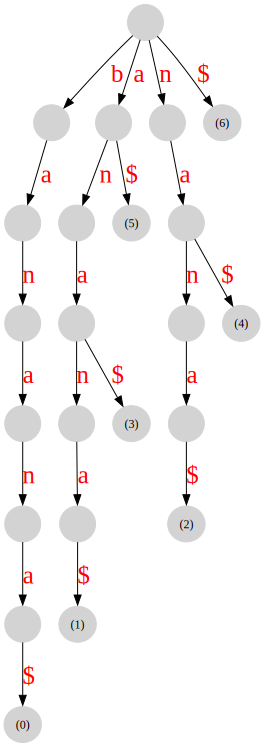

In [60]:
from graphviz import Digraph

class SuffixTreeNode:
    def __init__(self):
        self.children = {}  # Dictionary to hold children nodes (edge label -> child node)
        self.index = -1     # placeholder for final index of a suffix


class SuffixTree:
    def __init__(self, text):
        self.text = text + "$"  # add $
        self.root = SuffixTreeNode()
        self.build_suffix_tree()

    def build_suffix_tree(self):
        """
        build the suffix tree inserting all suffixes of the text
        """
        n = len(self.text)
        
        for i in range(n):
            current_node = self.root
            suffix = self.text[i:] # slice the string to make suffixes (i starts with 0 so all of the string first)

            for idx in range(len(suffix)):
                if suffix[idx] not in current_node.children: # character not found, create a new node
                    current_node.children[suffix[idx]] = SuffixTreeNode()
                current_node = current_node.children[suffix[idx]]  # Move to the child node
            current_node.index = i  # updates the index when suffix is placed

    # def search(self, pattern):
    #     """
    #     Search for a pattern in the text. Returns the starting index if found, otherwise -1.
    #     """
    #     current_node = self.root
    #     for char in pattern:
    #         if char not in current_node.children:
    #             return -1  # Pattern not found
    #         current_node = current_node.children[char]
        
    #     # Return the index of the suffix where the pattern is found
    #     return current_node.index

    def visualize(self, filename="suffix_tree"):
        """
        Visualize the suffix tree using Graphviz.
        """
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '10', 'fontcolor': 'blue', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self._visualize_helper(self.root, dot)
        dot.render(filename, format='png', cleanup=True)
        print(f"Visualization saved as {filename}.png")
        return dot

    def _visualize_helper(self, node, dot, parent_id="root", edge_label=""):
        """
        Helper method to add nodes and edges to the Graphviz object.
        """
        node_id = str(id(node))
        
        # Create node label
        if node.index != -1:
            label = f"({node.index})"
        else:
            label = ""

        dot.node(node_id, label, width="0.5", height="0.5", style="filled", color="lightgrey")

        # Add edge from parent to current node
        if parent_id != "root":
            dot.edge(parent_id, node_id, label=edge_label, fontsize="25", fontcolor="red")

        # Recursively add children
        for char, child_node in node.children.items():
            self._visualize_helper(child_node, dot, node_id, edge_label=char)


# Example usage:
text = "banana"
suffix_tree = SuffixTree(text)

# Visualize the tree using Graphviz
graph = suffix_tree.visualize()
display(graph)